## Sales Forecasting using Walmart data set.

<img width="1300" height="400" align="left" src="https://miro.medium.com/max/2760/1*gsUixexI9DsFfKsS-ZZqng.png">

<br>

### General Setup
___

In [1]:
# Dataframes.
import pandas as pd

# Numerical arrays.
import numpy as np

# Stationarity
from statsmodels.tsa.stattools import adfuller

# Predictions
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from pmdarima.arima.utils import ndiffs
from pmdarima.utils import diff_inv
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

# Plotting.
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

%matplotlib inline

In [2]:
# Change style and size of plots
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["figure.titlesize"] = 15

<br>

### Exploratory Data Analysis.
___

The data set consists of 4 csv files: stores, train, test, features. [3] First, I will analyse them separately. [4]

> [3] [Walmart Recruiting - Store Sales Forecasting: Data Description](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data)
<br>
[4] [Exploratory Data Analysis(EDA): Python](https://towardsdatascience.com/exploratory-data-analysis-eda-python-87178e35b14)

<br>

#### Stores.

_1. Load the file._

In [3]:
# Load the stores.csv without an index.
stores = pd.read_csv("Walmart Data Set/stores.csv", header=0)

# Display the dafaframe
stores.head()

,Store,Type,Size,Store A,Store B,Store C
0,1,A,151315,219622.0000,140167.0000,42988.00000
1,2,A,202307,39690.0000,34875.0000,39690.00000
2,4,A,205863,177247.7273,101190.7059,40541.66667
3,6,A,202505,NaN,NaN,NaN
4,8,A,155078,NaN,NaN,NaN


In [4]:
# Display the dafaframe
stores.tail()

,Store,Type,Size,Store A,Store B,Store C
40,37,C,39910,NaN,NaN,NaN
41,38,C,39690,NaN,NaN,NaN
42,42,C,39690,NaN,NaN,NaN
43,43,C,41062,NaN,NaN,NaN
44,44,C,39910,NaN,NaN,NaN


In [5]:
stores.describe()

,Store,Size,Store A,Store B,Store C
count,45.000000,45.000000,3.000000,3.000000,3.000000
mean,23.000000,130287.600000,145519.909100,92077.568633,41073.222223
std,13.133926,63825.271991,94068.443124,53234.277201,1712.049789
min,1.000000,34875.000000,39690.000000,34875.000000,39690.000000
25%,12.000000,70713.000000,108468.863650,68032.852950,40115.833335
50%,23.000000,126512.000000,177247.727300,101190.705900,40541.666670
75%,34.000000,202307.000000,198434.863650,120678.852950,41764.833335
max,45.000000,219622.000000,219622.000000,140167.000000,42988.000000


The stores file consist of information about 45 stores, including the type and size of each. We can observe that there are mainly empty values in the columns Store A, Store B and Store C. 



<br>

_2. Data cleaning._

The first step to cleansing the data is by checking it for empty values.

In [6]:
# Check for empty values.
stores.isnull().sum()

Store       0
Type        0
Size        0
Store A    42
Store B    42
Store C    42
dtype: int64

The above confirms that only the last three columns have the empty values. Since they do not provide enough information that could be valuable in the sales forecasting, they will be removed.

In [7]:
# Remove columns with empty values.
cleaned_stores = stores.drop(['Store A','Store B','Store C'], axis=1)

# Check for empty values again.
cleaned_stores.isnull().sum()

Store    0
Type     0
Size     0
dtype: int64

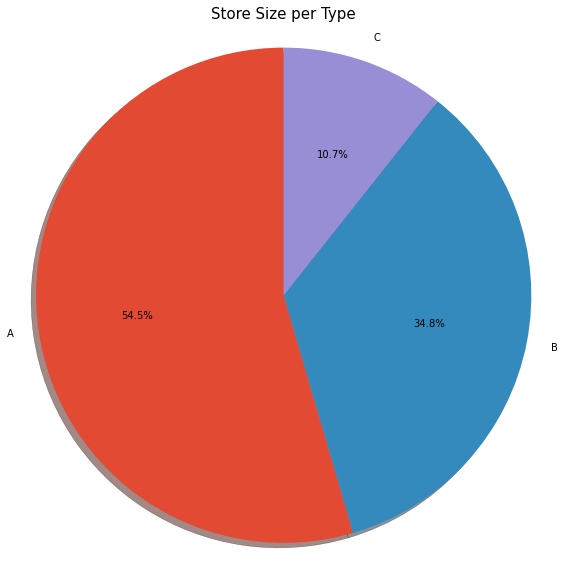

In [8]:
# Calculate maximum values of each store type and set as pie sizes
sizes = cleaned_stores.groupby('Type').max().Size.values
labels = cleaned_stores.groupby('Type').max().index

# Create a figure and axis, set a title.
fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle("Store Size per Type")

# Build a pie plot.
ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal') 

# Show the plot.
plt.tight_layout()
plt.show()

<br>

#### Train.


In [9]:
# Load the train.csv without an index.
train = pd.read_csv("Walmart Data Set/train.csv", header=0, parse_dates=True, index_col="Date")

# Display the dafaframe.
train.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [10]:
# Display the dafaframe.
train.tail()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2012-09-28,45,98,508.37,False
2012-10-05,45,98,628.10,False
2012-10-12,45,98,1061.02,False
2012-10-19,45,98,760.01,False
2012-10-26,45,98,1076.80,False


In [11]:
train.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


The above dataframe contains weekly sales for 45 stores per department for the period from 2010-02-05 to 2012-10-26. We can see that altogether there are 99 departments. It also includes the department number and whether the week is a special holiday week.

In [12]:
# Check for empty values.
train.isnull().sum()

Store           0
Dept            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

The dataframe doesn't have any empty values.

In [13]:
depts = train.groupby("Store").Dept.nunique()
print(f"Maximum Departments: {np.max(depts)}\nMinimum Departments: {np.min(depts)}")

Maximum Departments: 79
Minimum Departments: 61


It is clear that the stores have different distribution of departments.

In [14]:
# Plot the data by year
g = sns.catplot(x='IsHoliday', y='Weekly_Sales', data=train)
g.fig.set_size_inches(10,8)

# Show the plot.
plt.title("Weekly Sales vs Holiday")
plt.tight_layout()
plt.show()

<br>

#### Features.

In [ ]:
# Load the features.csv without an index.
features = pd.read_csv("Walmart Data Set/features.csv", header=0, parse_dates=True, index_col="Date")

# Display the dafaframe
features.head()

In [ ]:
# Display the dafaframe
features.tail()

The features file contains additional data related to the store, department, and regional activity for the given dates. MarkDown columns are related to promotional markdowns that Walmart is running. 

In [ ]:
features.describe()

In [ ]:
# Check for empty values.
features.isnull().sum()

In [ ]:
features.loc['2011-11-1': '2011-11-30']

We can see that MarkDowns appear from 11.11.2011.

In [ ]:
features = features.loc['2011-11-11': '2013-07-26']
features

In [ ]:
def date_format(ax, int):
    # Make the x axis display well.
    weeks = mdates.DayLocator(int)
    h_fmt = mdates.DateFormatter('%d-%m-%Y')

    # Tick ax axis.
    ax.xaxis.set_major_locator(weeks)
    ax.xaxis.set_major_formatter(h_fmt)

In [ ]:
# Calculate mean of columns in features.
temp = features[features["Store"]==1].groupby(["Date"]).mean()

# Create a figure and a set of axis
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2, figsize=(15,12))

# Date Format.
fig.autofmt_xdate()

# Plot the data.
ax1.plot(temp.MarkDown1)
ax1.title.set_text("MarkDown 1")
ax2.plot(temp.MarkDown2)
ax2.title.set_text("MarkDown 2")
ax3.plot(temp.MarkDown3)
ax3.title.set_text("MarkDown 3")
ax4.plot(temp.MarkDown4)
ax4.title.set_text("MarkDown 4")

# Show the plots.
plt.show()

In [ ]:
# Fill the missing values.
features["MarkDown1"].fillna(method="ffill", inplace=True)
features["MarkDown2"].fillna(method="ffill", inplace=True)
features["MarkDown3"].fillna(method="bfill", inplace=True)
features["MarkDown4"].fillna(method="ffill", inplace=True)

In [ ]:
# Create a figure and a set of axis
fig, [ax1,ax2] = plt.subplots(1,2)

# Date Format.
fig.autofmt_xdate()

# Plot the data.
ax1.plot(temp.CPI)
ax1.title.set_text("CPI")
ax2.plot(temp.Unemployment)
ax1.title.set_text("Unemployment")

# Show the plots.
plt.show()

In [ ]:
# Filling missing values for CPI and unemployment
features["CPI"].fillna(method="ffill", inplace=True)
features["Unemployment"].fillna(method="ffill", inplace=True)

In [ ]:
# Checking for missing values again.
features.isnull().sum()

In [ ]:
# Separate test features from train.
features_train = features.loc['2011-11-11': '2012-10-26'].reset_index()
features_test = features.loc['2012-11-02': '2013-07-26'].reset_index()
features_train.head()

<br>

### Mergining data sets.
___

In [ ]:
# Merge the dataframes into one.
df = train.merge(features_train, on=['Store', 'IsHoliday', 'Date'],how='left').dropna()
df = df.merge(cleaned_stores, on=['Store'], how='left')

# Timedelta
#df['Date'] = df['Date'] + pd.to_timedelta(df.groupby('Date').cumcount(), unit='m')
df=df.set_index(['Date'])

# Display the new dataframe with a date index.
df

In [ ]:
df.index.duplicated().sum()

In [ ]:
df.isnull().sum()

In [ ]:
# Create a figure and axis.
fig, ax = plt.subplots(figsize=(13,10))
fig.suptitle("Weekly Sales")

# Date formatter.
date_format(ax,10)
fig.autofmt_xdate()

# Plot the sales
sns.scatterplot(data=df, x=df.index, y="Weekly_Sales", ax=ax)

# Show the plot.
plt.tight_layout()
plt.show()

In [ ]:
# Create a figure and axis.
fig, ax = plt.subplots(figsize=(13,10))
fig.suptitle("Correlation Map")

# Plot the correlation
corr = df.corr()
cmap = sns.diverging_palette(100, 275, as_cmap=True)
sns.heatmap(corr, cmap=cmap, center=0, annot=True,square=True,cbar_kws={"shrink": .7}, ax=ax)

# Set a title and rotate x axis 
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot.
plt.show()

The heatmap shows that weekly sales are dependent on:
* Store Size
* Department
* MarkDown5, MarkDown1, MarkDown3, MarkDown4, MarkDown2
* IsHoliday

<br>
    
### Holidays & Markdowns

In [ ]:
# Create a figure and axis.
fig, ax = plt.subplots(figsize=(20,8))
fig.suptitle("Weekly Sales per Store")

# Plot the data by year
per_store = df.groupby("Store").agg({"Weekly_Sales": "sum"})
per_store.sort_values("Weekly_Sales").plot.bar(ax=ax)

# Set a title and change rotation of xticks back to 0 
plt.title("2011-2012")
plt.xticks(rotation=0)

# Show the plot.
plt.show()

In [ ]:
"""
def test_stationarity(ts):
    # Create a figure and axis.
    fig, ax = plt.subplots()
    fig.suptitle('Rolling Mean & Standard Deviation')

    # Date Format.
    date_format(ax,10)
    fig.autofmt_xdate()

    # Determing rolling statistics
    rolmean = ts["Weekly_Sales"].rolling(12).mean()
    rolstd = ts["Weekly_Sales"].rolling(12).std()

    # Plot rolling statistics:
    sns.lineplot(data=ts, x="Date", y="Weekly_Sales", ax=ax, label='Original')
    sns.lineplot(data=ts, x="Date", y=rolmean, ax=ax, label='Rolling Mean')
    sns.lineplot(data=ts, x="Date", y=rolstd, ax=ax, label = 'Rolling Std')

    # Show the plot
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)

sales_df = pd.DataFrame(df["Weekly_Sales"])
test_stationarity(sales_df)
"""

### Preprocessing

In [ ]:
# Change to pivot table per department and tore
sales = pd.pivot_table(df,index=df.index,columns=[df.Store, df.Dept], values='Weekly_Sales',aggfunc=np.sum)

# Stack the pivot table and remove rows with more than 10% (apprx 5) missing values
sales = sales.dropna(thresh=len(sales) - 5, axis=0)

In [ ]:
sales = sales.fillna(method="bfill")
sales = sales.fillna(method="ffill")
sales.isnull().sum().any()

In [ ]:
sales.head()

In [ ]:
res = STL(sales.values.flatten(), period=7).fit()
res.plot()
plt.show()

<br>

### ARIMA model.
___

In [ ]:
def get_dept():
    depts_sales = []
    for i,j in sales:
        dept_sales = sales.loc[:, (i, j)]
        depts_sales.append(dept_sales)
    return depts_sales

In [ ]:
def split(dept_sales):
    size = int(len(dept_sales) * 0.7)
    train, val = dept_sales[0:size], dept_sales[size:]
    return train, val

In [ ]:
def adf(dept_sales):
    dftest = adfuller(dept_sales, autolag='AIC')
    values = []
    for key,value in dftest[4].items():
        values.append(value)
    return dftest[0], values[0]

In [ ]:
def make_stationary(dept_sales):
    dept_sales_diff = dept_sales.diff().dropna()
    return dept_sales_diff

In [ ]:
def inv_diff (df_orig_column,df_diff_column, periods):
    # Generate np.array for the diff_inv function - it includes first n values(n = 
    # periods) of original data & further diff values of given periods
    value = np.array(df_orig_column[:periods].tolist()+df_diff_column[periods:].tolist())

    # Generate np.array with inverse diff
    inv_diff_vals = diff_inv(value, periods,1 )[periods:]
    return inv_diff_vals

In [ ]:
def arima(dept_sales, train, val):
    # Create a model
    model = auto_arima(dept_sales, start_p=0, start_q=0, start_P=0, start_Q=0,
                        test='adf', # use Augmented Dickey-Fuller(adftest) test to find optimal 'd'
                      trend="ct", stationary=True,
                      stepwise=False)
    model.fit(train)
    preds = model.predict(n_periods=len(val))
    val_vs_forecast = plot(preds, val)
    return val_vs_forecast

In [ ]:
def plot(preds, val):
    forecast_df = pd.DataFrame(preds,index = val.index,columns=['Prediction'])
    
    val_vs_forecast = pd.concat([val,forecast_df],axis=1)
    val_vs_forecast.plot()
    plt.title(f'RMSE: {rmse(val, forecast_df):.2f}')    
    return val_vs_forecast

In [ ]:
def rmse(val, preds):
    rmse = np.sqrt(mean_squared_error(val, preds))
    return rmse

In [ ]:
def predictions_per_dept(dept_sales):
    train, val = split(dept_sales)
    #test_stat, crit_val = adf(dept_sales)
    #if test_stat > crit_val:
    #    dept_sales_diff = make_stationary(dept_sales)
    #    train_diff, val_diff = split(dept_sales_diff)
     #   val_vs_forecast = arima(dept_sales_diff, train_diff, val_diff)
    val_vs_forecast = arima(dept_sales, train, val)
    return val_vs_forecast

In [ ]:
predictions = pd.DataFrame()
depts_sales = get_dept()
predictions = predictions.merge(predictions_per_dept(depts_sales[9]), on="Date", how="left")
predictions.T

In [ ]:
# Future forecast
predictions = pd.DataFrame()
warnings.filterwarnings("ignore")
depts_sales = get_dept()
for i in range(0, 3):
    preds = predictions_per_dept(depts_sales[i])
    predictions = predictions.append(preds)

In [ ]:
predictions

NameError: name 'predictions' is not defined

In [ ]:
# Create a figure and axis.
fig, ax = plt.subplots()

ax.plot(val, label='Original')
ax.plot(preds, label='Predicted', color='b')

plt.legend()
plt.show()

In [ ]:
train, val = split(pd.DataFrame(depts_sales[9]))

In [ ]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(order):
    # prepare training dataset
    model = ARIMA(train, order=order).fit()
    predictions = model.predict(start=1, end=len(val), typ='levels')
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(val, predictions))
    return rmse

In [ ]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                rmse = evaluate_arima_model(order)
                if rmse < best_score:
                    best_score, best_cfg = rmse, order
    print(f'Best ARIMA {best_cfg}: RMSE={best_score:.3f}')

# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)

### Test data.

In [ ]:
# Load the train.csv without an index.
test_data = pd.read_csv("Walmart Data Set/test.csv", header=0, parse_dates=True, index_col="Date")

# Display the dafaframe.
test_data.head()

In [ ]:
test_data.tail()

In [ ]:
test_df = test_data.merge(features_test, on=['Store', 'IsHoliday', 'Date'],how='left')
test_df.index = test_df.Date
test_df = test_df.drop("Date", axis=1)
test_df.head()

In [ ]:
test_df.tail()

In [ ]:
test_df.isnull().sum()

### References 

> 1.[How to group pandas DataFrame entries by date in a non-unique column](https://stackoverflow.com/questions/11391969/how-to-group-pandas-dataframe-entries-by-date-in-a-non-unique-column)<br>
2. [Date tick labels](https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/date.html)<br>
3. [Pandas Groupby: Summarising, Aggregating, and Grouping data in Python](https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/#multiple-statistics-per-group)<br>
4. [Augmented Dickey-Fuller Test in Python](http://www.hackdeploy.com/augmented-dickey-fuller-test-in-python/)<br>
5. [A comprehensive beginner’s guide to create a Time Series Forecast (with Codes in Python and R)](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/)<br>
6. [Using Python and Auto ARIMA to Forecast Seasonal Time Series](https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c)<br>
7. [python pandas : split a data frame based on a column value](https://stackoverflow.com/questions/36192633/python-pandas-split-a-data-frame-based-on-a-column-value)<br>
8. [How should I Handle duplicate times in time series data with pandas?](https://stackoverflow.com/questions/44128600/how-should-i-handle-duplicate-times-in-time-series-data-with-pandas)
9. [pandas dataframe select columns in multiindex [duplicate]](https://stackoverflow.com/questions/25189575/pandas-dataframe-select-columns-in-multiindex)